In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import segmentation_models as sm
import os
import cv2
from PIL import Image
sm.set_framework('tf.keras')
sm.framework()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import glob

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
#loading the datasets
normal = "./Dataset_BUSI_with_GT/normal/"
benign = "./Dataset_BUSI_with_GT/benign/"
malignant = "./Dataset_BUSI_with_GT/malignant/"


In [3]:
#counting the len of files
count_normal = len(os.listdir(normal))
count_benign = len(os.listdir(benign))
count_malignant = len(os.listdir(malignant))
count_normal, count_benign, count_malignant

(266, 891, 421)

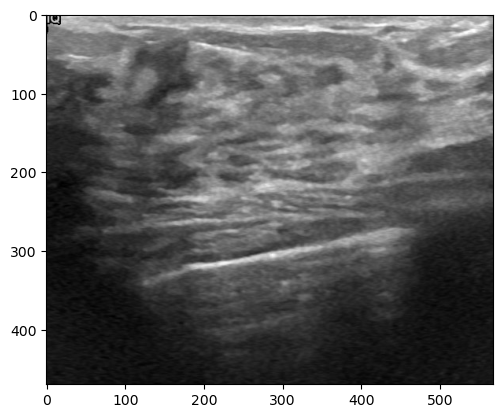

In [4]:
#normal_cases = os.listdir(normal)
#normal_img = []
#for i in normal_cases:
#    filename = normal+i
#    normal_img.append(filename)
#same thing can e done using glob.glob command
#We can use the function glob.glob() or glob.iglob() directly from glob module to retrieve paths recursively from inside the directories/files and subdirectories/subfiles.
%matplotlib inline
normal_cases = glob.glob(normal +"*")
img2 = cv2.imread(normal_cases[0])
plt.imshow(img2)
malignant_cases = glob.glob(malignant +"*")
benign_cases = glob.glob(benign +"*")

In [5]:
# An empty list. We will insert the data into this list in (img_path, label) format, i.e image path plus image name
exclude= [] # as some images contain 2 or more masks in malignant and benign cases
train_data_mask = []
train_data_img=[]

#first we create the empty lists then append it
for img in normal_cases:
    if img.endswith("_mask.png"):
        train_data_mask.append(img)
    else:
        train_data_img.append(img)

for img in malignant_cases:
    if img.endswith("_mask.png"):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

for img in benign_cases:
    if img.endswith("_mask.png"):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

In [6]:
len(train_data_img), len(train_data_mask), len(exclude)


(780, 780, 18)

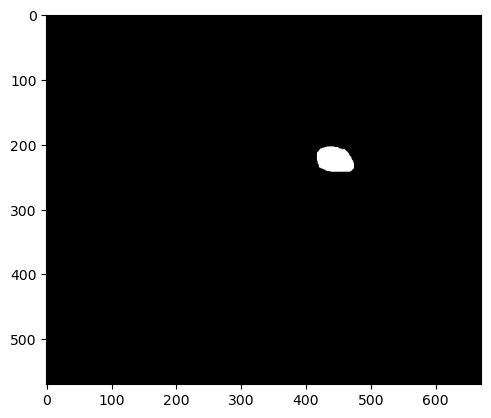

In [7]:
train_data_img = sorted(train_data_img) #sorting the files in alphabetical order
train_data_mask = sorted(train_data_mask)
img1 = cv2.imread(train_data_mask[57],0)
plt.imshow(img1, cmap = "gray")

In [39]:
#resizing the images and appending the datasets in the form of numpy array
img_set = []
mask_set = []
for i in train_data_img:
    image = cv2.imread(i) #loading a singly layer as its a grey scale image, to avoid using extra space
    image_resize = cv2.resize(image, (128,128))
    img_set.append(np.array(image_resize))

for i in train_data_mask:
    mask = cv2.imread(i,0)
    mask_resize = cv2.resize(mask, (128,128))
    #setting a threshold to convert anything above 127 pixel value to 255 (i.e white color)
    (thresh, binary)= cv2.threshold(mask_resize, 127,255, cv2.THRESH_BINARY)
    mask_set.append(np.array(binary))

In [40]:
len(img_set), len(mask_set), type(img_set)

(780, 780, list)

In [41]:
#converting the list to array, dividing it by 255, then increasing its dimension
inp_img = np.array(img_set)
inp_data = inp_img/255.
print(inp_data.shape) #expanding the dimension at 3rd axis, to make it 4D



(780, 128, 128, 3)


In [43]:
mask_img = np.array(mask_set)
mask_data = mask_img/255.
print(mask_data.shape) #expanding the dimension at 3rd axis, to make it 4D

mask = np.expand_dims(mask_data, axis = 3)
mask.shape

(780, 128, 128)


(780, 128, 128, 1)

./Dataset_BUSI_with_GT/benign\benign (342).png


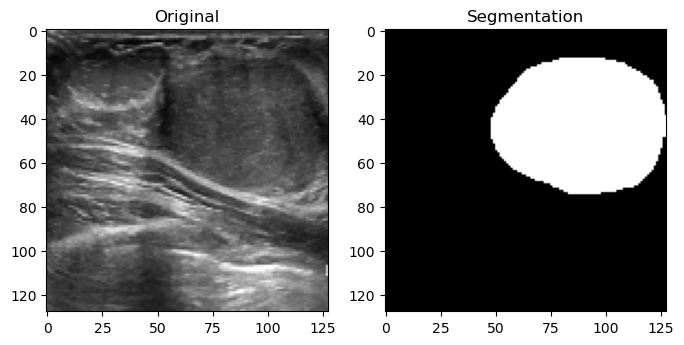

In [44]:
#plotting the images
n1 = np.random.randint(0,len(inp_data))
print(train_data_img[n1])
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(inp_data[n1,:,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.title("Segmentation")
plt.imshow(mask_data[n1,:,:,], cmap = "gray")


In [45]:
#next step is training the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inp_data, mask,test_size=0.15, random_state = 0)


In [46]:
BACKBONE = "resnet34" 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [47]:
X_train_pre = preprocess_input(X_train)
X_test_pre = preprocess_input(X_test)

In [48]:
del(X_train)
del(X_test)

In [49]:
#cheking unique values of y_test
np.unique(y_test)

array([0., 1.])

In [51]:
model = sm.Unet(BACKBONE, input_shape=(128,128,3), encoder_weights=None, activation="sigmoid")

In [52]:
model.compile("Adam", loss = sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score] )

In [53]:
X_train_pre.shape

(663, 128, 128, 3)

In [54]:
model.fit(X_train_pre,y_train, epochs=10, verbose=1, batch_size = 20, validation_data=(X_test_pre, y_test))

Epoch 1/10
34/34 [==============================] - 278s 8s/step - loss: 1.3028 - iou_score: 0.1359 - val_loss: 1591.8365 - val_iou_score: 0.0719
Epoch 2/10
34/34 [==============================] - 272s 8s/step - loss: 0.9368 - iou_score: 0.2716 - val_loss: 452.2887 - val_iou_score: 0.0966
Epoch 3/10
34/34 [==============================] - 271s 8s/step - loss: 0.8013 - iou_score: 0.3710 - val_loss: 536.9595 - val_iou_score: 0.0788
Epoch 4/10
34/34 [==============================] - 275s 8s/step - loss: 0.7444 - iou_score: 0.4235 - val_loss: 853.0981 - val_iou_score: 0.0852
Epoch 5/10
34/34 [==============================] - 3429s 101s/step - loss: 0.7007 - iou_score: 0.4616 - val_loss: 19.3551 - val_iou_score: 0.1217
Epoch 6/10
34/34 [==============================] - 263s 8s/step - loss: 0.6805 - iou_score: 0.4814 - val_loss: 16.9767 - val_iou_score: 0.0919
Epoch 7/10
34/34 [==============================] - 268s 8s/step - loss: 0.6267 - iou_score: 0.5234 - val_loss: 2.7912 - val_iou

n2 = np.random.randint(0, len(X_test_pre)
y_test = X_test_pre[n2]
y_test.shape


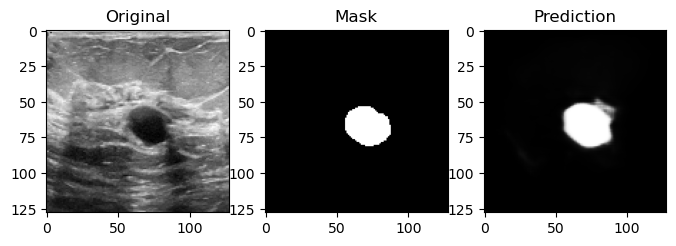

In [85]:
n2 = np.random.randint(0, len(X_test_pre))
test_img = X_test_pre[n2] 
test_img.shape
test_img1 = np.expand_dims(test_img, axis = 0)
ypred = model.predict(test_img1)
pred_img = (ypred[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(8,6))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(test_img, cmap = "gray")

plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(y_test[n2][:,:,0], cmap = "gray")

plt.subplot(1,3,3)
plt.title("Prediction")
pred = np.expand_dims(ypred, axis = 2)
plt.imshow(ypred[0], cmap = "gray")
plt.show()

In [79]:
y_test.shape

(117, 128, 128, 1)